In [1]:
#Import required libraries and CSV file
import pandas as pd 
import numpy as np
pd.options.display.max_columns=50
df=pd.read_csv('/Users/apple/desktop/Data_Analysis_Projects/Global Startup Ecosystem/Dataset/investments_VC.csv',encoding="ISO-8859-1")

In [2]:
#Dropping all rows where the entire instances have a NaN
#Stripping all leading and trailing white spaces
def prel_clean(df):
    df=df.dropna(how='all')
    df.columns=df.columns.str.strip()
    return df

In [3]:
df=prel_clean(df)

In [4]:
#Creating a new DF with all startups that have duplicated names only
def dup(df,name):
    df_dup=pd.DataFrame()
    lst=df[df.name.duplicated()].name.to_list()
    for i in lst:
        df_dup=df_dup.append(df.loc[df.name==i])
    return df_dup

In [5]:
#Dropping all duplicated DFs where they have the same Name, Homepage URL, and Country Code
def drop_dup(df):
    df=df.drop_duplicates(subset=['name','homepage_url','country_code'],keep='first',inplace=True)
    return df

In [6]:
#Drop all instances where the values inside (Category List, Market, Funding Total usd, Country Code, Region, Market) is NULL
df=df.drop(df.loc[(df.category_list=="NAN") & df['market'].isna() & df['funding_total_usd'].isna() & df['country_code'].isna() & df['region'].isna() & df['market'].isna()].index,axis=0)

In [7]:
drop_dup(df)

In [8]:
#Amending the Categoty List by adjusting the text and sorting in alphabetically
def categ_list(df):
    x=df.category_list.replace(np.nan,'NAN').str.strip('|').str.replace('|',',').str.split(',').to_list()
    z=[sorted(i) for i in x]
    x2=[','.join(i) for i in z]
    df.category_list=pd.DataFrame(x2)
    return df

In [9]:
df.loc[df['category_list']=="NAN",'category_list']=df.loc[df['category_list']=="NAN"'market']

In [10]:
df=categ_list(df)

In [11]:
#Amending the Total Funding column
def fund_total(df):
    df.funding_total_usd=df.funding_total_usd.str.replace(',','').str.replace('-','NAN').str.strip('-').astype(float)
    return df

In [12]:
df=fund_total(df)

In [13]:
#Creating a new column (total_fund_check), where we add all the funding sub-categories 
def sum_frame_by_column(df, new_col_name,new_col_name_2,list_of_cols_to_sum):
    df[new_col_name] = df[list_of_cols_to_sum].astype(float).sum(axis=1)
    return df

In [14]:
df=sum_frame_by_column(df, 'total_fund_check','Value Check', ['seed','venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding'])

In [15]:
#After creating the new column (total_fund_check), we will match all instances between funding_total_usd and total_fund_check and for every instance where the former is missing and the latter has a value, replace the former with the latter's value
def match_fund(df):
    z=df.loc[(df.funding_total_usd!=df.total_fund_check)].index.to_list()
    for i in z:
        if (df.loc[i,'funding_total_usd']==np.nan) & (df.loc[i,'total_fund_check']!=0):
            df.funding_total_usd=df.Total_fund_outsourced
    return df

In [16]:
df=match_fund(df)

In [17]:
#Checking that the null values in the 3 columns (founded_quarter, founded_year, founded_month) are at the same instances
for i in ['founded_year','founded_quarter']:
    if df.loc[df.founded_month.isnull()].index.to_list()==df.loc[df[i].isnull()].index.to_list():
        print(True)
        
#Checked that all indexes in column founded_at where the value in NaN is a subset in the list of indexes for column founded_month where the value is NaN
if set(df.loc[df.founded_at.isnull()].index.to_list()).issubset(set(df.loc[df.founded_month.isnull()].index.to_list())):
    print(True)

#We can drop (founded_quarter, founded_year, founded_month) since the missing values in column (founded_at) are all a subset of the 3 columns' missing values

#Function to study the correlation between the 'founded_at' and 'first_funding_at' to check whether we can replace the missing values in column (founded_at) with the values of (first_funding_at)
def date_col(df):
    df_corr=pd.DataFrame()
    df_corr['founded_at_1']=df.founded_at.str[:4]
    df_corr['first_funding_at_1']=df.first_funding_at.str[:4]
    df_corr.dropna(inplace=True)
    df_corr=df_corr.astype(float)
    return df_corr.corr()
date_col(df)

#Adjusting column (founded_at) to take only the year and dropping everything else
def found_at_adj(df):
    df.founded_at=df.founded_at.str[:4]
    return df

True
True
True


In [18]:
df=found_at_adj(df)

In [19]:
#Dropping unneccesary columns 
def drop_col(df):
    df=df.drop(['founded_quarter','founded_year','founded_month','permalink','state_code','round_A','round_B','round_C','round_D','round_E','round_F','round_G','round_H'], axis=1)
    df=df.drop(df.loc[df['country_code'].isna() & df['founded_at'].isna()].index)
    return df

In [20]:
df=drop_col(df)

In [21]:
#Check if all NaN instances in country and region are a subset of all NaN instances in City
#For any missing country code, if we have another instance that has same region and a valid Area -> Replace missing country code with the valid one
for i in ['country_code','region']:
    if set(df.loc[df[i].isnull()].index.to_list()).issubset(set(df.loc[df.city.isnull()].index.to_list())):
        print(True)
        
def count_rep(df):
    loc_not_0=df[(df.region.notna())]
    dct={}
    for i,j in loc_not_0[['country_code','region']].groupby('region'):
        dct[i]=list(j.country_code.unique())
    dct={i:[k for k in j if str(k)!=np.nan] for i,j in dct.items() if (np.nan in j)&(len(j)>1)}
    for i,j in dct.items():
        df.loc[(df.region==i)&(df.country_code.isna()),'country_code']=j[0]

True
True


In [22]:
#Replacing missing values in the category list with values in market list
def fill_miss_catlist(df):
    return df['category_list'].fillna(df.market, inplace=True)

In [23]:
fill_miss_catlist(df)

In [24]:
#Resetting Index
df.reset_index(drop=True, inplace=True)

Analysis and Plotting

In [25]:
from matplotlib import rc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [91]:
import os
os.chdir(r"/Users/apple/Desktop")
#os. getcwd() 

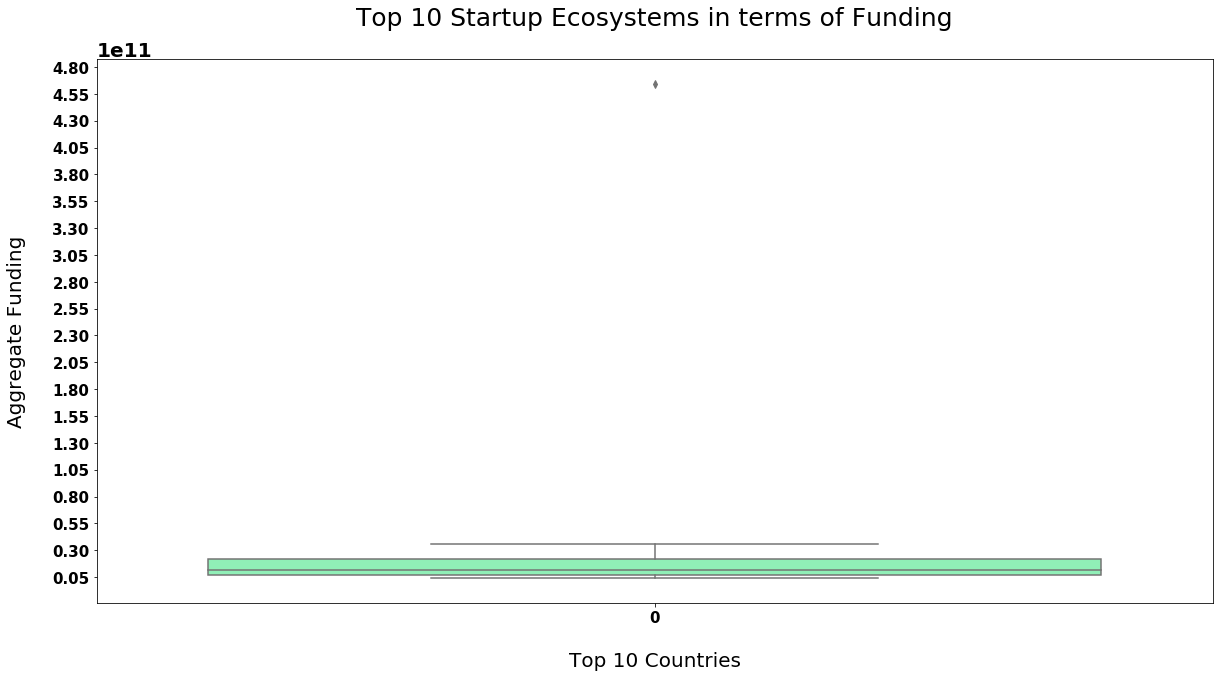

In [131]:
#Top 10 countries in terms of aggregate funding in the startup scene
x=df.groupby('country_code')['funding_total_usd'].agg('sum').sort_values(ascending=False).head(10)

#PLOT: Boxplot showing where the majority of funding in the startup scene lie and which country is an outlier
%config InlineBackend.figure_format='png'
fig,ax=plt.subplots(figsize=(20,10))
sns.boxplot(data=x,palette='rainbow')
ax.yaxis.set_ticks(np.arange(5e+9, 5e+11, 25e+9))
ax.set_xlabel('\nTop 10 Countries', fontsize=20)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
ax.set_ylabel('Aggregate Funding\n', fontsize=20)
ax.set_title('Top 10 Startup Ecosystems in terms of Funding\n', fontsize=25)
plt.savefig('img1.png');

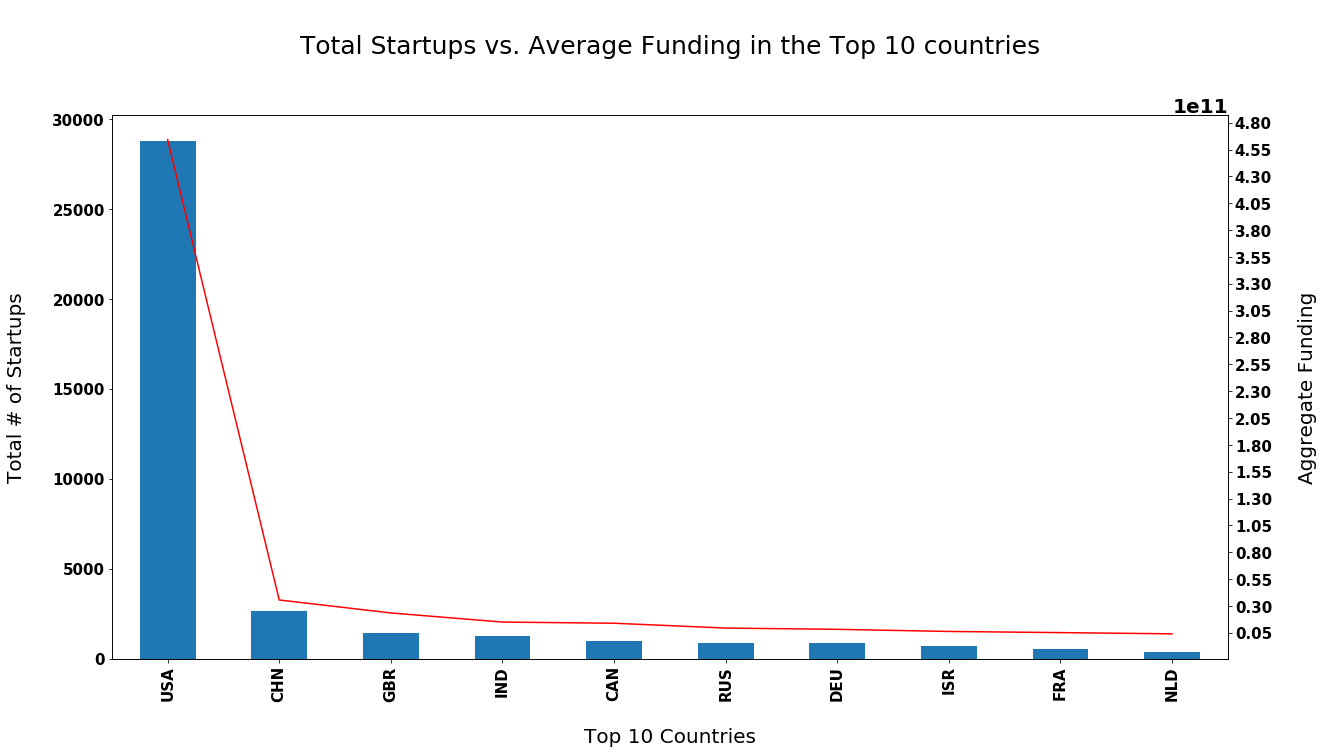

In [130]:
#Top 10 countries that dominate that startup scene (total # of startups initiated)
x=df.country_code.value_counts().head(10)
y=df.groupby('country_code')['funding_total_usd'].agg('sum').sort_values(ascending=False).head(10)

#PLOT
fig,ax=plt.subplots(figsize=(20,10))
ax=x.plot(kind='bar')
ax.set_xlabel('\nTop 10 Countries', fontsize=20)
ax.set_ylabel('Total # of Startups\n', fontsize=20)
ax2=ax.twinx()
ax2.plot(y, color='r')
ax2.set_ylabel('\nAggregate Funding', fontsize=20)
ax2.yaxis.set_ticks(np.arange(5e+9, 5e+11, 25e+9))
plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)
plt.yticks(fontsize= 15)
ax.set_title('\nTotal Startups vs. Average Funding in the Top 10 countries\n\n', fontsize=25);

In [99]:
#Distribution of funding based on funding stage for top 10 countries
df_fund=df.groupby('country_code')[['seed','venture','equity_crowdfunding','undisclosed','convertible_note','debt_financing','angel','grant','private_equity','post_ipo_equity','post_ipo_debt','secondary_market','product_crowdfunding']].agg('sum')
x=df_fund.loc[df.country_code.value_counts().head(10).index.to_list()]

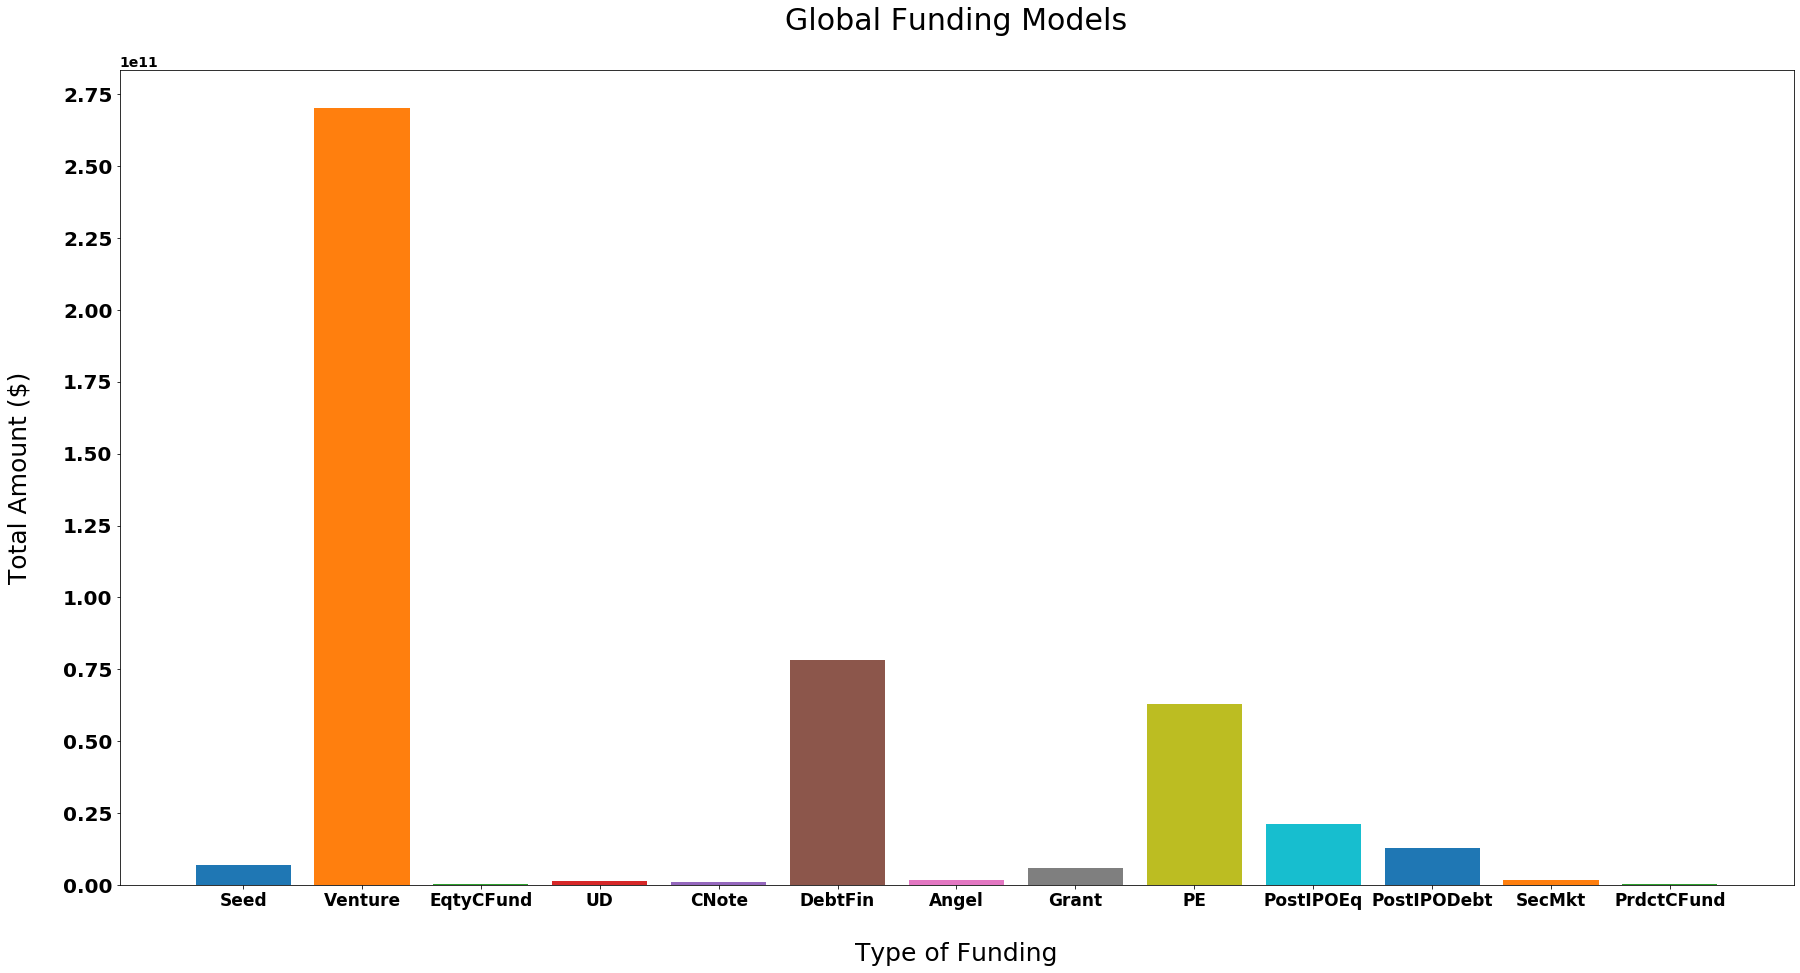

In [107]:
#PLOT:Distribution of funds based on funding type for top 10 countries
mpl.rcParams['font.size'] = 14
labels = ['Seed', 'Venture', 'EqtyCFund', 'UD', 'CNote','DebtFin','Angel','Grant','PE','PostIPOEq','PostIPODebt','SecMkt','PrdctCFund']
fig,ax=plt.subplots(figsize=(30,15))
for i in range(len(labels)):
    ax.bar(labels[i],x.iloc[:,(i)])
ax.yaxis.set_ticks(np.arange(0, 300000000000, 25000000000))
ax.set_xlabel('\nType of Funding', fontsize=25)
ax.set_ylabel('Total Amount ($)\n', fontsize=25)
ax.set_title('Global Funding Models\n', fontsize=30)
plt.xticks(fontsize= 17)
plt.yticks(fontsize= 20);

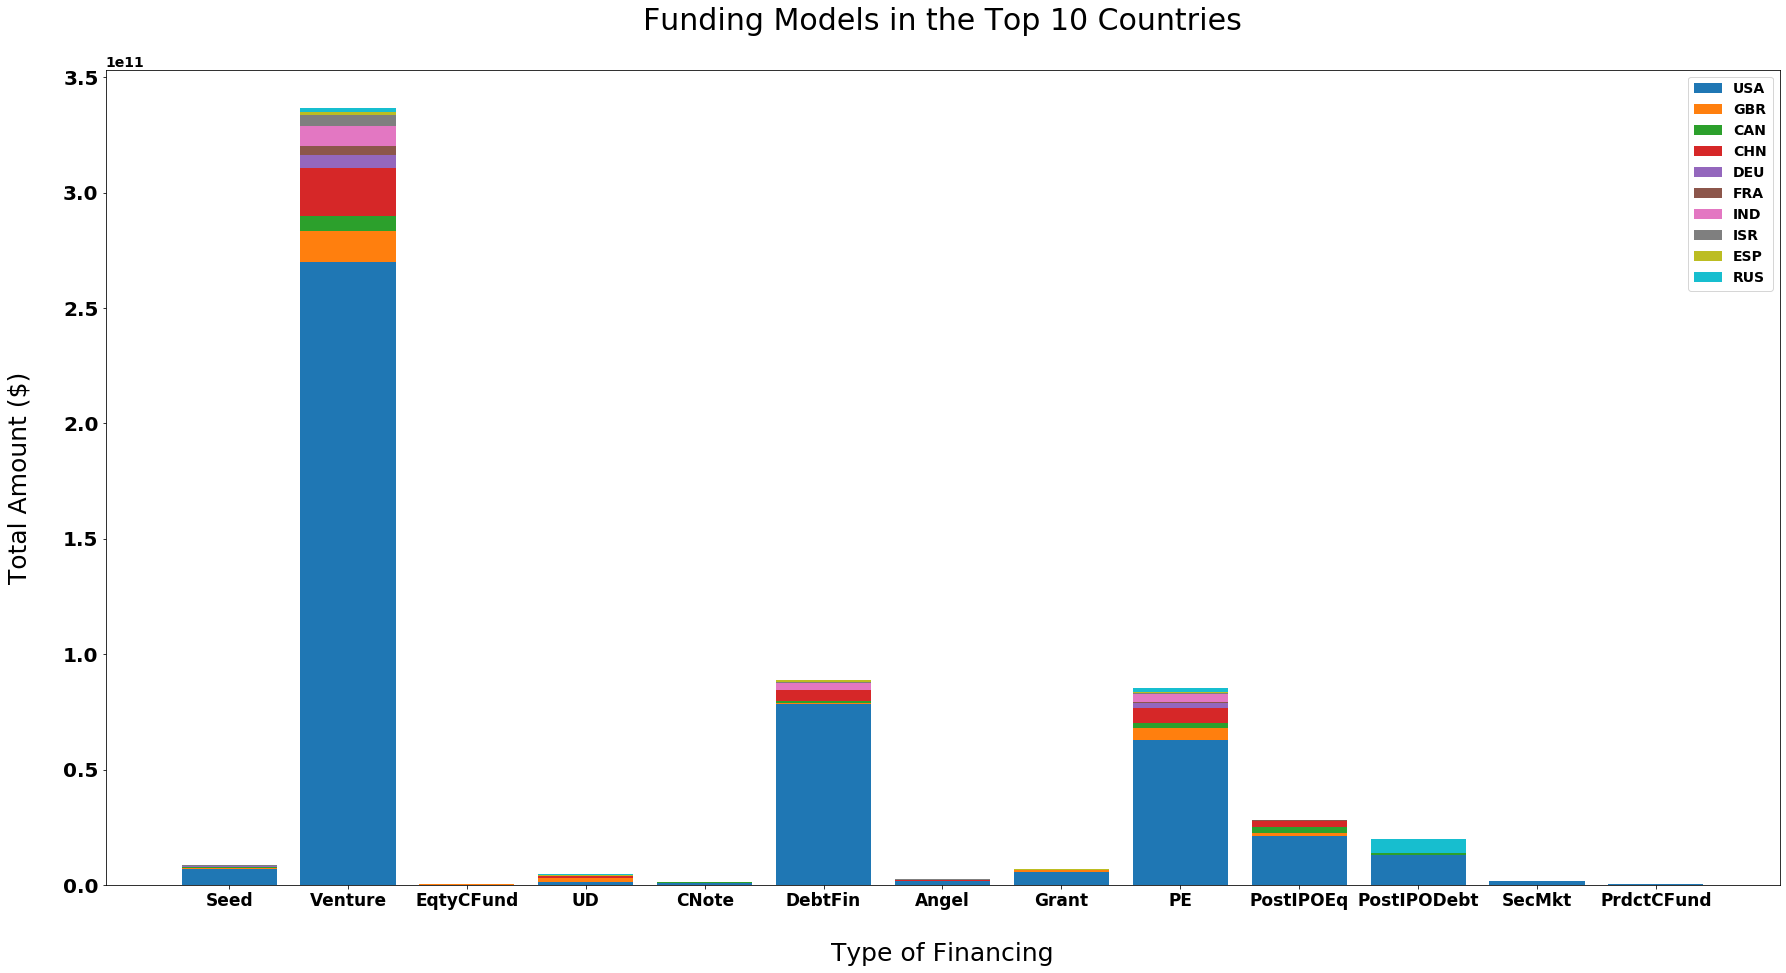

In [109]:
#PLOT:Distribution of funds based on funding type for each of the Top 10 Countries
rc('font', weight='bold')
mpl.rcParams['font.size'] = 14

r=[0,1,2,3,4,5,6,7,8,9,10,11,12]
labels = df.country_code.value_counts().head(10).index.to_list()
x=df_fund.loc[df.country_code.value_counts().head(10).index.to_list()]

#for i in range(len(labels)):
    #xi=x.iloc[i,:].to_list()

x0=x.iloc[0,:].to_list()
x1=x.iloc[1,:].to_list()
x2=x.iloc[2,:].to_list()
x3=x.iloc[3,:].to_list()
x4=x.iloc[4,:].to_list()
x5=x.iloc[5,:].to_list()
x6=x.iloc[6,:].to_list()
x7=x.iloc[7,:].to_list()
x8=x.iloc[8,:].to_list()
x9=x.iloc[9,:].to_list()
    
bars_1=np.add(x0,x1).tolist()
bars_2=np.add(bars_1,x2).tolist()
bars_3=np.add(bars_2,x3).tolist()
bars_4=np.add(bars_3,x4).tolist()
bars_5=np.add(bars_4,x5).tolist()
bars_6=np.add(bars_5,x6).tolist()
bars_7=np.add(bars_6,x7).tolist()
bars_8=np.add(bars_7,x8).tolist()

barWidth = 1
labels_2 = ['Seed', 'Venture', 'EqtyCFund', 'UD', 'CNote','DebtFin','Angel','Grant','PE','PostIPOEq','PostIPODebt','SecMkt','PrdctCFund']


fig,ax=plt.subplots(figsize=(30,15))

ax.bar(r,x0)
ax.bar(r,x1, bottom=x0)
ax.bar(r,x2, bottom=bars_1)
ax.bar(r,x3, bottom=bars_2)
ax.bar(r,x4, bottom=bars_3)
ax.bar(r,x5, bottom=bars_4)
ax.bar(r,x6, bottom=bars_5)
ax.bar(r,x7, bottom=bars_6)
ax.bar(r,x8, bottom=bars_7)
ax.bar(r,x9, bottom=bars_8)

plt.xticks(r, labels_2, fontweight='bold', fontsize=14)
plt.legend(labels)
ax.set_xlabel('\nType of Financing', fontsize=25)
ax.set_ylabel('Total Amount ($)\n', fontsize=25)
ax.set_title('Funding Models in the Top 10 Countries\n', fontsize=30)
plt.xticks(fontsize= 17)
plt.yticks(fontsize= 20);

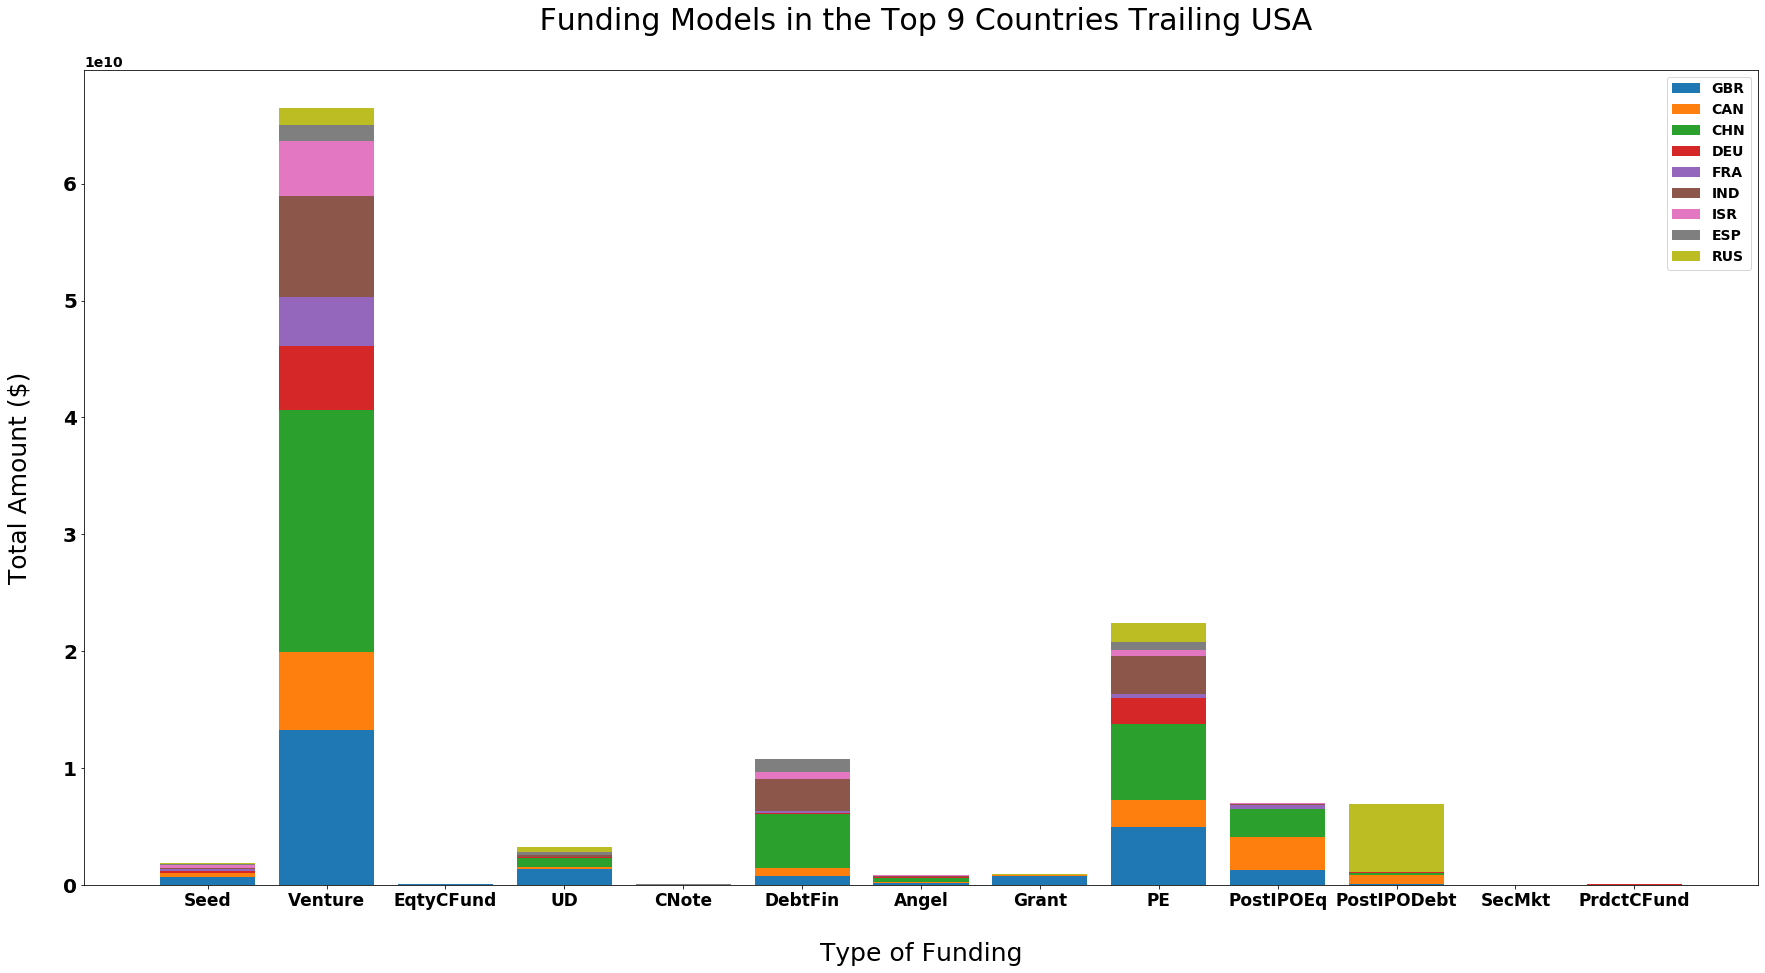

In [115]:
#PLOT:Distribution of funds based on funding type for each of the Top 9 Countries after USA
rc('font', weight='bold')
mpl.rcParams['font.size'] = 14

r=[0,1,2,3,4,5,6,7,8,9,10,11,12]
labels = df.country_code.value_counts().head(10).index.to_list()[1:10]
x=df_fund.loc[df.country_code.value_counts().head(10).index.to_list()][1:10]

#for i in range(len(labels)):
    #xi=x.iloc[i,:].to_list()

x0=x.iloc[0,:].to_list()
x1=x.iloc[1,:].to_list()
x2=x.iloc[2,:].to_list()
x3=x.iloc[3,:].to_list()
x4=x.iloc[4,:].to_list()
x5=x.iloc[5,:].to_list()
x6=x.iloc[6,:].to_list()
x7=x.iloc[7,:].to_list()
x8=x.iloc[8,:].to_list()
    
bars_1=np.add(x0,x1).tolist()
bars_2=np.add(bars_1,x2).tolist()
bars_3=np.add(bars_2,x3).tolist()
bars_4=np.add(bars_3,x4).tolist()
bars_5=np.add(bars_4,x5).tolist()
bars_6=np.add(bars_5,x6).tolist()
bars_7=np.add(bars_6,x7).tolist()

barWidth = 1
labels_2 = ['Seed', 'Venture', 'EqtyCFund', 'UD', 'CNote','DebtFin','Angel','Grant','PE','PostIPOEq','PostIPODebt','SecMkt','PrdctCFund']


fig,ax=plt.subplots(figsize=(30,15))

ax.bar(r,x0)
ax.bar(r,x1, bottom=x0)
ax.bar(r,x2, bottom=bars_1)
ax.bar(r,x3, bottom=bars_2)
ax.bar(r,x4, bottom=bars_3)
ax.bar(r,x5, bottom=bars_4)
ax.bar(r,x6, bottom=bars_5)
ax.bar(r,x7, bottom=bars_6)
ax.bar(r,x8, bottom=bars_7)

plt.xticks(r, labels_2, fontweight='bold', fontsize=14)
plt.legend(labels)
ax.set_xlabel('\nType of Funding', fontsize=25)
ax.set_ylabel('Total Amount ($)\n', fontsize=25)
ax.set_title(' Funding Models in the Top 9 Countries Trailing USA\n',fontsize=30)
plt.xticks(fontsize= 17)
plt.yticks(fontsize= 20);

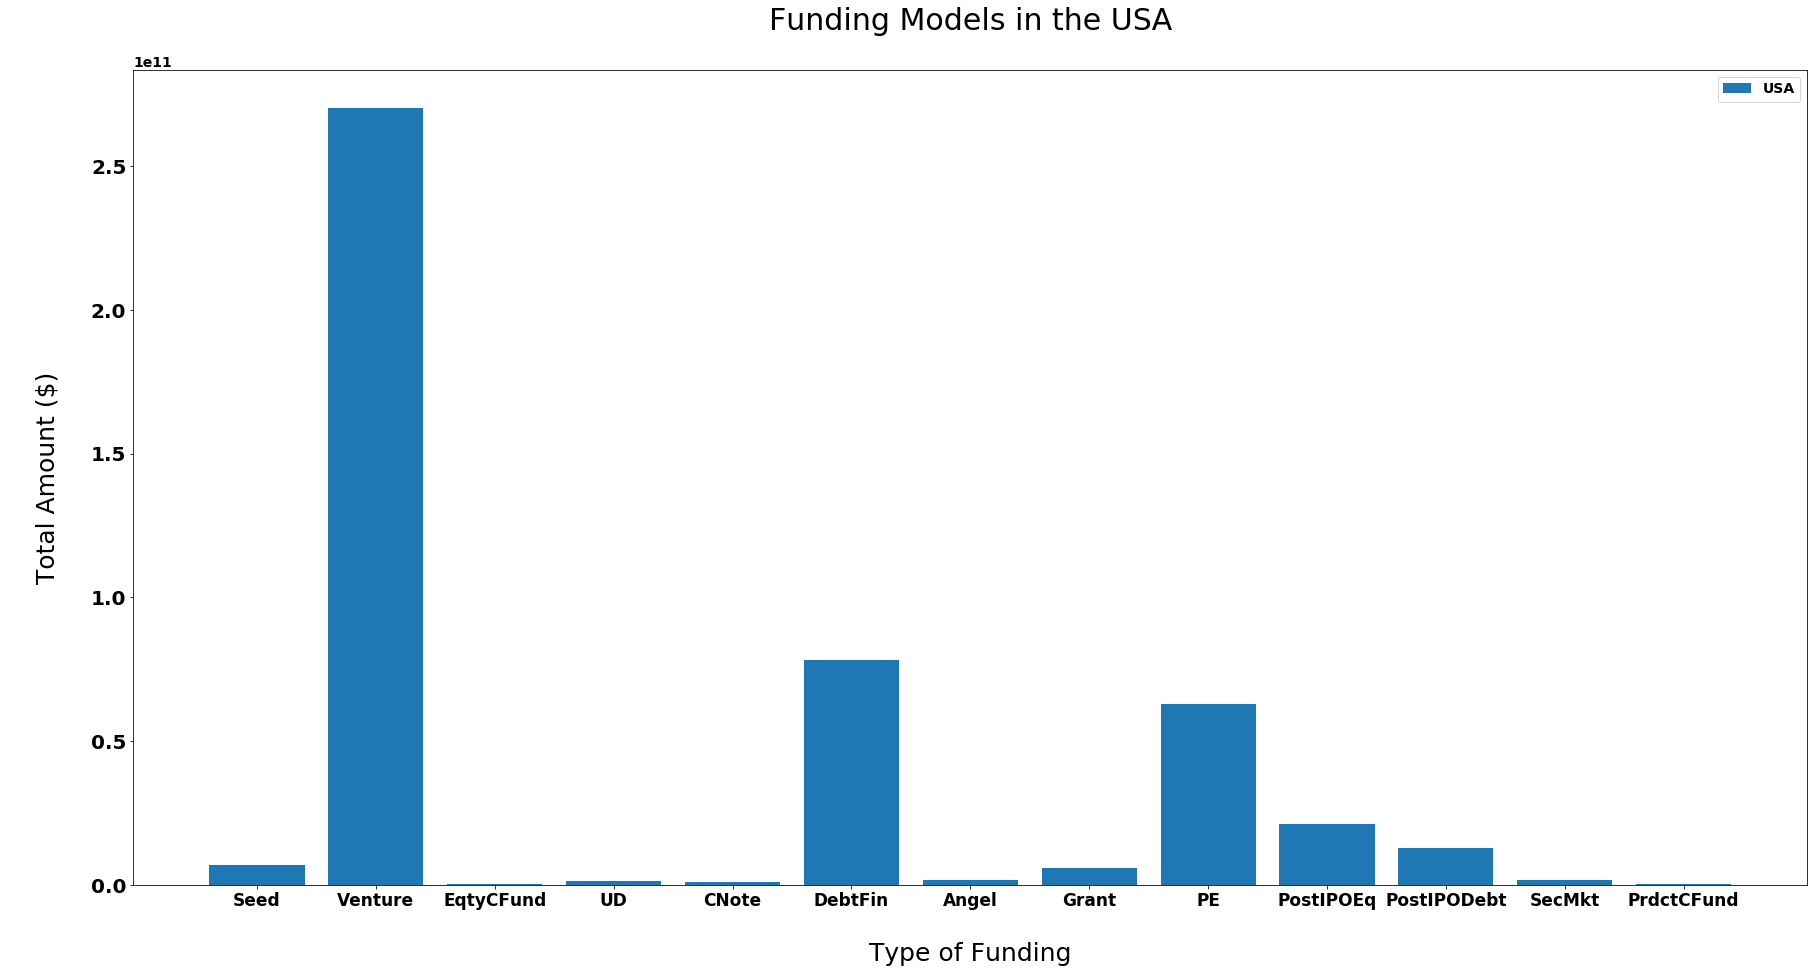

In [117]:
#PLOT:Distribution of funds based on funding type for USA
rc('font', weight='bold')
mpl.rcParams['font.size'] = 14

r=[0,1,2,3,4,5,6,7,8,9,10,11,12]
labels = df.country_code.value_counts().head(1).index.to_list()
x=df_fund.loc[df.country_code.value_counts().head(1).index.to_list()]

x0=x.iloc[0,:].to_list()

barWidth = 1
labels_2 = ['Seed', 'Venture', 'EqtyCFund', 'UD', 'CNote','DebtFin','Angel','Grant','PE','PostIPOEq','PostIPODebt','SecMkt','PrdctCFund']


fig,ax=plt.subplots(figsize=(30,15))

ax.bar(r,x0)

plt.xticks(r, labels_2, fontweight='bold')
plt.legend(labels)
ax.set_xlabel('\nType of Funding', fontsize=25)
ax.set_ylabel('\nTotal Amount ($)\n', fontsize=25)
ax.set_title('Funding Models in the USA\n', fontsize=30)
plt.xticks(fontsize= 17)
plt.yticks(fontsize= 20);

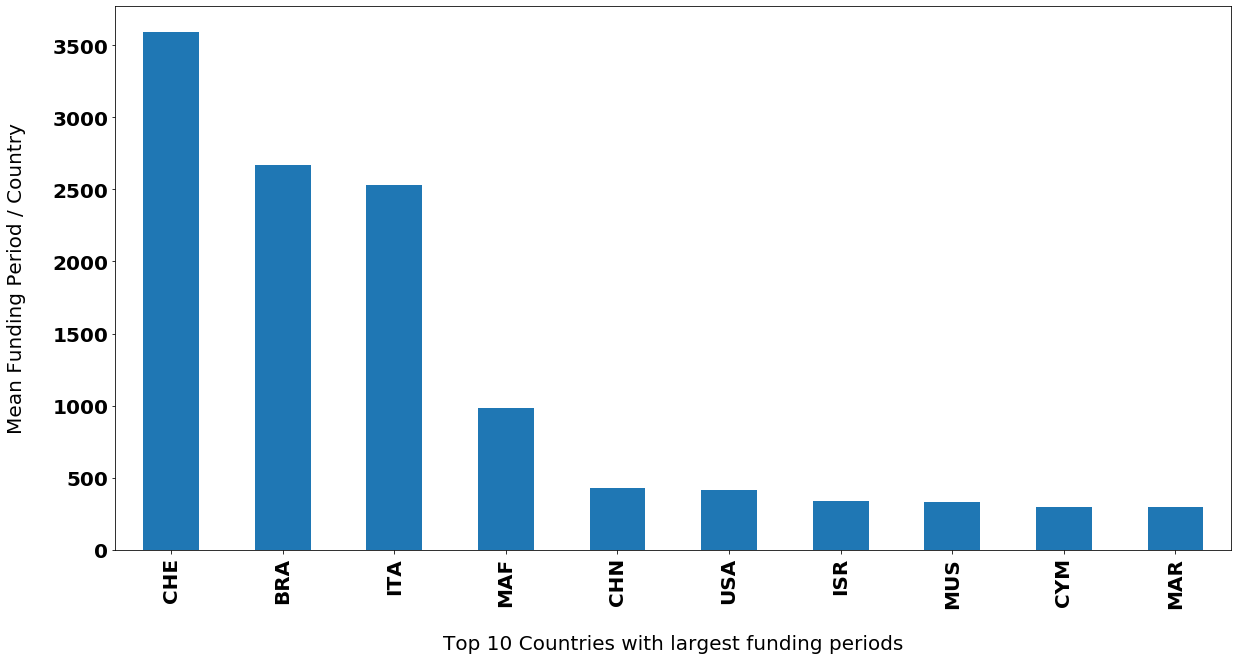

In [84]:
#Calculating the difference in days between first and last funding date & displaying top 10 countries with the largest average funding period
import datetime
lst=[]
for i in range(df.shape[0]):
    mdate = df.last_funding_at[i]
    rdate = df.first_funding_at[i]
    mdate1 = datetime.datetime.strptime(mdate, "%Y-%m-%d").date()
    rdate1 = datetime.datetime.strptime(rdate, "%Y-%m-%d").date()
    delta =  (mdate1 - rdate1).days
    lst.append(delta)
df['fund_days']=pd.DataFrame(lst)
z=df.groupby('country_code')['fund_days'].agg('mean').sort_values(ascending=False).head(10)

#PLOT
plt.figure(figsize=(20,10))
z.plot(kind='bar')
plt.xlabel('\nTop 10 Countries with largest funding periods')
plt.ylabel('Mean Funding Period / Country\n');

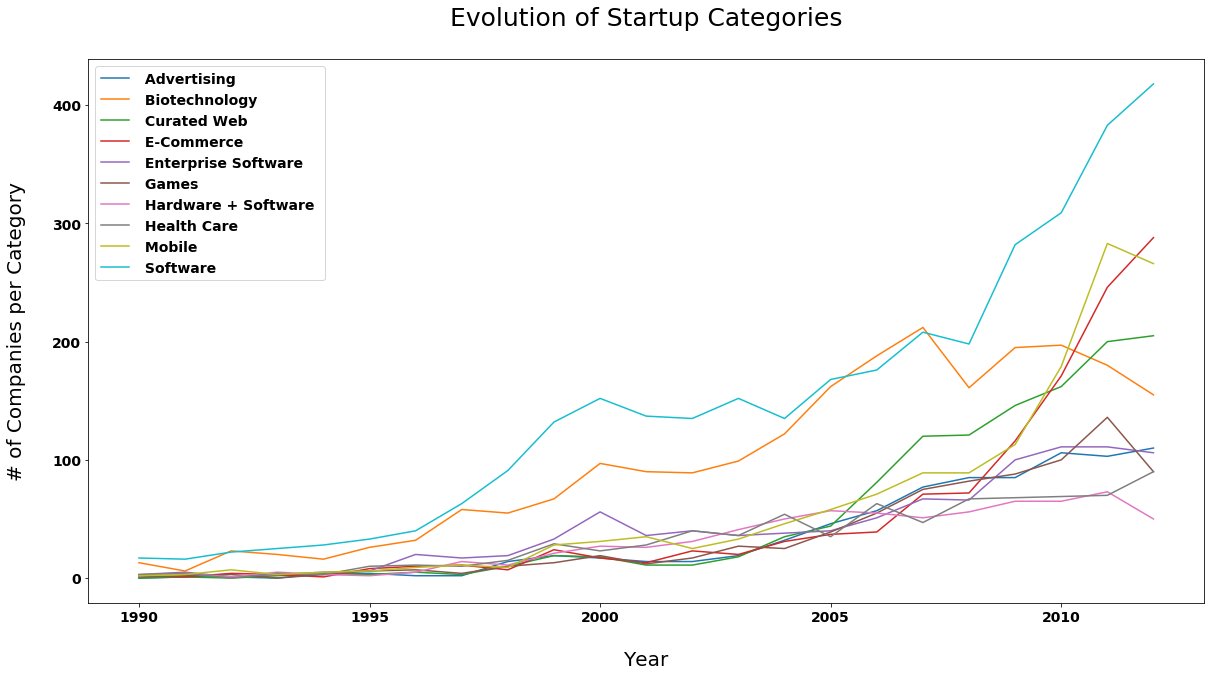

In [129]:
#PLOT: Evolution of number of startups per category since 1990
mpl.rcParams['font.size'] = 14
df_20years=df[(df.founded_at>='1990')& (df.founded_at<'2013')]
top_cat=df_20years.market.value_counts()[:10].index.tolist()
df_top_cat=df_20years[df_20years.market.isin(top_cat)] #filtering
df_top_crosstab=pd.crosstab(df_top_cat.founded_at,df_top_cat.market)
df_top_crosstab.plot(kind='line',figsize=(20,10))
mpl.rcParams['font.size'] = 20
plt.ylabel('# of Companies per Category\n', fontsize=20)
plt.xlabel('\nYear', fontsize=20)
plt.title('Evolution of Startup Categories\n', fontsize=25)
plt.legend(prop={'size': 14})
plt.savefig('img6.png');

In [51]:
#Top 10 categories for startups (based on Market) 
df.market.value_counts().head(10)

 Software                4514
 Biotechnology           3609
 Mobile                  1884
 E-Commerce              1731
 Curated Web             1569
 Enterprise Software     1264
 Health Care             1182
 Clean Technology        1144
 Games                   1113
 Hardware + Software     1059
Name: market, dtype: int64

In [55]:
#Top 10 categories with their respective aggregated funding total
df.groupby(['market'])['funding_total_usd'].agg('sum').sort_values(ascending=False).head(10)

market
 Biotechnology           7.226928e+10
 Mobile                  4.879982e+10
 Software                4.189455e+10
 Clean Technology        3.662700e+10
 Health Care             2.934574e+10
 E-Commerce              2.192777e+10
 Enterprise Software     1.925955e+10
 Finance                 1.715144e+10
 Hardware + Software     1.263877e+10
 Advertising             1.253515e+10
Name: funding_total_usd, dtype: float64

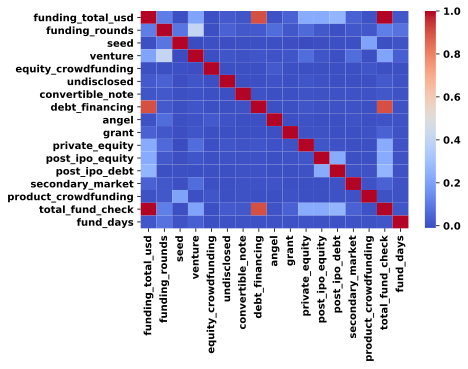

In [200]:
#Heatmap
sns.heatmap(df.corr(),cmap='coolwarm')

In [79]:
df

,name,homepage_url,category_list,market,funding_total_usd,status,country_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,total_fund_check
0,#waywire,http://www.waywire.com,"Entertainment,News,Politics,Social Media",News,1750000.0,acquired,USA,New York City,New York,1.0,2012,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1750000.0
1,&TV Communications,http://enjoyandtv.com,Games,Games,4000000.0,operating,USA,Los Angeles,Los Angeles,2.0,NaN,2010-06-04,2010-09-23,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4000000.0
2,'Rock' Your Paper,http://www.rockyourpaper.org,"Education,Publishing",Publishing,40000.0,operating,EST,Tallinn,Tallinn,1.0,2012,2012-08-09,2012-08-09,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40000.0
3,(In)Touch Network,http://www.InTouchNetwork.com,"Apps,Coffee,E-Commerce,Electronics,Guides,Mobi...",Electronics,1500000.0,operating,GBR,London,London,1.0,2011,2011-04-01,2011-04-01,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500000.0
4,-R- Ranch and Mine,NaN,"Entertainment,Games,Tourism",Tourism,60000.0,operating,USA,Dallas,Fort Worth,2.0,2014,2014-08-17,2014-09-26,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47187,Zytoprotec,http://www.zytoprotec.com,Biotechnology,Biotechnology,2686600.0,operating,AUT,Vienna,Gerasdorf Bei Wien,1.0,2007,2013-01-29,2013-01-29,0.0,2686600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2686600.0
47188,Zzish,http://www.zzish.com,Education,Education,320000.0,operating,GBR,London,London,1.0,2013,2014-03-24,2014-03-24,320000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320000.0
47189,ZZNode Science and Technology,http://www.zznode.com,Enterprise Software,Enterprise Software,1587301.0,operating,CHN,Beijing,Beijing,1.0,NaN,2012-04-01,2012-04-01,0.0,1587301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1587301.0
47190,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,Web Development,Web Development,97398.0,operating,HRV,Split,Split,5.0,2012,2011-11-01,2014-09-10,71525.0,0.0,0.0,0.0,25873.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97398.0
